<a href="https://colab.research.google.com/github/gayathrig269/CMPE260_Rfmt_Learning_TicTacToe/blob/main/Part3_Neural_Network_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Neural Network to play Tic Tac Toe

To train a Neural Network to play Tic Tac Toe, the following are defined:

1. The Topology of the neural network, i.e. how do the input and output layers look like. How many hidden layers and how big?

2. A loss function. The loss function will take the output of the Neural Network and return a value indicating how good that output was.

3.     A training part which will try to adjust the weights in the Neural Network as to minimize the loss function.

##Tic Tac Toe Q-learning Graph

For the Neural Network Tic Tac Toe agent, our graph will have the follwing things:



  1. An input layer which takes a game state, i.e. the current board, as input.
  2. One or more hidden layer.
  3. An output layer which will output the Q value for all possible moves in that game state.
  4. We use Mean Squared Error as our loss function, which is a generic and popular loss function for regression, i.e. learning to mimic another function.
  5. The input for the loss function will be the output of the Neural Network and our updated estimate of the Q function by applying the discounted rewards and maximum Q values of the next states. i.e. the loss will be the difference between the output of the Neural Network and our updated estimate of the Q function.
  6. We use the Gradient Descent Optimizer for training — i.e. to adjust the weights in the Neural Network. 
  7. We use ReLu activation function.

Files used :

*   SimpleNNQPlayer.py
*   util.py
*   Board.py
*   Player.py
*   TFSessionManager.py





#Demonstration code of Neural Network Player playing TTT game starts here

In [1]:
#Mounting the google drive contents of TIC-TAC_TOE code 
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/tic_tac_toe_master/'

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/tic_tac_toe_master/

/content/gdrive/My Drive/tic_tac_toe_master


In [ ]:
#installing the required version of Tensorflow
!pip install tensorflow==1.15.0

Testing our Neural Network player against other players

In [15]:
from Board import Board
from util import battle
from Player import Player
from TFSessionManager import TFSessionManager
import tensorflow as tf

#Defining evaluate_players function
#This function accepts 2 players as arguemnts and plots a graph showing their performance for 100 games.
def evaluate_players(p1 : Player, p2 : Player, games_per_battle = 100, num_battles = 100,loc='best'):
    board = Board()

    p1_wins = []
    p2_wins = []
    draws = []
    game_number = []
    game_counter = 0

    TFSessionManager.set_session(tf.Session())
    TFSessionManager.get_session().run(tf.global_variables_initializer())

    for i in range (num_battles):
        p1win, p2win, draw = battle(p1, p2, games_per_battle, False)
        p1_wins.append(p1win)
        p2_wins.append(p2win)
        draws.append(draw)
        game_counter=game_counter+1
        game_number.append(game_counter)

    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(game_number, draws, 'r-', label='Draw')
    plt.plot(game_number, p1_wins, 'g-', label='Player 1 wins')
    plt.plot(game_number, p2_wins, 'b-', label='Player 2 wins')
    plt.legend(loc=loc, shadow=True, fancybox=True, framealpha =0.7)

    TFSessionManager.set_session(None)
    return game_number, p1_wins, p2_wins, draws

#1. Against the Random Player

Player 1 will be our Neural Network player, and Player 2 will be the Random Player. We assume it should be easy for the Neural Network player to win most games, but we hope it will learn to win much more than we would expect from a Random Player playing first.

After 100 game we have draws: 12, Player 1 wins: 47, and Player 2 wins: 41.
Which gives percentages of draws: 12.00%, Player 1 wins: 47.00%, and Player 2 wins:  41.00%
After 100 game we have draws: 9, Player 1 wins: 74, and Player 2 wins: 17.
Which gives percentages of draws: 9.00%, Player 1 wins: 74.00%, and Player 2 wins:  17.00%
After 100 game we have draws: 9, Player 1 wins: 74, and Player 2 wins: 17.
Which gives percentages of draws: 9.00%, Player 1 wins: 74.00%, and Player 2 wins:  17.00%
After 100 game we have draws: 5, Player 1 wins: 74, and Player 2 wins: 21.
Which gives percentages of draws: 5.00%, Player 1 wins: 74.00%, and Player 2 wins:  21.00%
After 100 game we have draws: 8, Player 1 wins: 80, and Player 2 wins: 12.
Which gives percentages of draws: 8.00%, Player 1 wins: 80.00%, and Player 2 wins:  12.00%
After 100 game we have draws: 9, Player 1 wins: 74, and Player 2 wins: 17.
Which gives percentages of draws: 9.00%, Player 1 wins: 74.00%, and Player 2 wins:  17.00%
Af

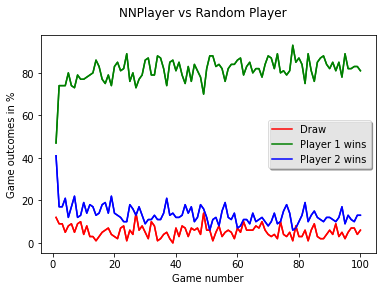

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

Since there are some non-deterministic parts in this, the results will vary to a degree, but we see the Neural Network player improve its game over time, in the end winning the vast majority of games. In particular it should win significantly more games than the Random Player. For many executions it ended up winning about 90% of games on average in the end and lose less than 10%.



Neural Network Player goes second

After 100 game we have draws: 15, Player 1 wins: 55, and Player 2 wins: 30.
Which gives percentages of draws: 15.00%, Player 1 wins: 55.00%, and Player 2 wins:  30.00%
After 100 game we have draws: 20, Player 1 wins: 48, and Player 2 wins: 32.
Which gives percentages of draws: 20.00%, Player 1 wins: 48.00%, and Player 2 wins:  32.00%
After 100 game we have draws: 15, Player 1 wins: 41, and Player 2 wins: 44.
Which gives percentages of draws: 15.00%, Player 1 wins: 41.00%, and Player 2 wins:  44.00%
After 100 game we have draws: 18, Player 1 wins: 38, and Player 2 wins: 44.
Which gives percentages of draws: 18.00%, Player 1 wins: 38.00%, and Player 2 wins:  44.00%
After 100 game we have draws: 15, Player 1 wins: 39, and Player 2 wins: 46.
Which gives percentages of draws: 15.00%, Player 1 wins: 39.00%, and Player 2 wins:  46.00%
After 100 game we have draws: 11, Player 1 wins: 31, and Player 2 wins: 58.
Which gives percentages of draws: 11.00%, Player 1 wins: 31.00%, and Player 2 wins: 

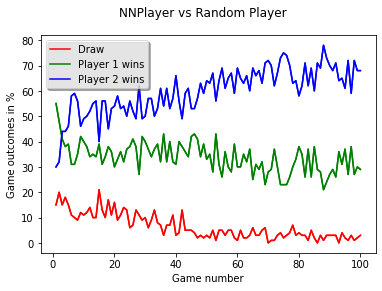

In [17]:
tf.reset_default_graph()    

rndplayer = RandomPlayer() #Player1
nnplayer = NNQPlayer("QLearner1") #Player2


game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer)

plt.suptitle("NNPlayer vs Random Player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

Again, the Neural Network player improves its game over time. It typically started to beat the Random Player more often than it lost after about 20 battles and in the end would win about 80% of the games and lose around 20%.

In both cases, the player does not play draws very often. In fact they happen much less often than during pure random play.

#2. Against the (deterministic) Min Max Player 

Neural Network player goes first

After 100 game we have draws: 19, Player 1 wins: 0, and Player 2 wins: 81.
Which gives percentages of draws: 19.00%, Player 1 wins: 0.00%, and Player 2 wins:  81.00%
After 100 game we have draws: 49, Player 1 wins: 0, and Player 2 wins: 51.
Which gives percentages of draws: 49.00%, Player 1 wins: 0.00%, and Player 2 wins:  51.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

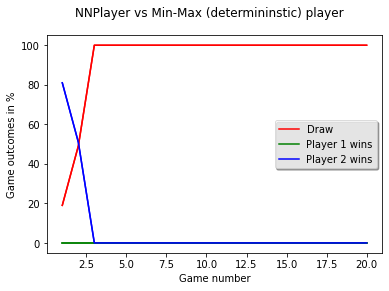

In [18]:
from MinMaxAgent import MinMaxAgent

tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles = 20)

plt.suptitle("NNPlayer vs Min-Max (determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

It seems that either it converges to 100% draw or 100% losses with no middle ground or change after it reached 100% of either. 

Neural Network moving second

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
Afte

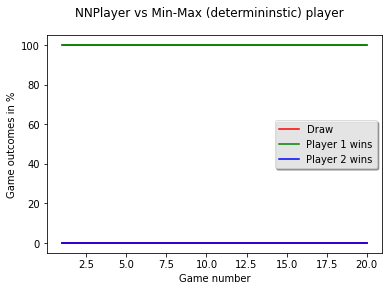

In [19]:
tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
mm_player = MinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(mm_player,nnplayer, num_battles = 20)

plt.suptitle("NNPlayer vs Min-Max (determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

It converges to 100% losses. 

#3. Against the non-deterministic Min Max Player

Neural Network player goes first

After 100 game we have draws: 90, Player 1 wins: 0, and Player 2 wins: 10.
Which gives percentages of draws: 90.00%, Player 1 wins: 0.00%, and Player 2 wins:  10.00%
After 100 game we have draws: 85, Player 1 wins: 0, and Player 2 wins: 15.
Which gives percentages of draws: 85.00%, Player 1 wins: 0.00%, and Player 2 wins:  15.00%
After 100 game we have draws: 92, Player 1 wins: 0, and Player 2 wins: 8.
Which gives percentages of draws: 92.00%, Player 1 wins: 0.00%, and Player 2 wins:  8.00%
After 100 game we have draws: 65, Player 1 wins: 0, and Player 2 wins: 35.
Which gives percentages of draws: 65.00%, Player 1 wins: 0.00%, and Player 2 wins:  35.00%
After 100 game we have draws: 66, Player 1 wins: 0, and Player 2 wins: 34.
Which gives percentages of draws: 66.00%, Player 1 wins: 0.00%, and Player 2 wins:  34.00%
After 100 game we have draws: 68, Player 1 wins: 0, and Player 2 wins: 32.
Which gives percentages of draws: 68.00%, Player 1 wins: 0.00%, and Player 2 wins:  32.00%
After 

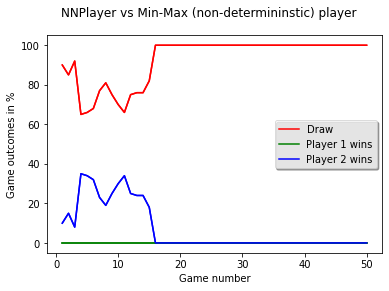

In [20]:
from RndMinMaxAgent import RndMinMaxAgent

tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rnd_mm_player, num_battles = 50)

plt.suptitle("NNPlayer vs Min-Max (non-determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')


Observation:
Again, results are mixed. Sometimes we get close to 100% draws, but everything between 0% and 100% seems possible.

When NN Player goes second !

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 ga

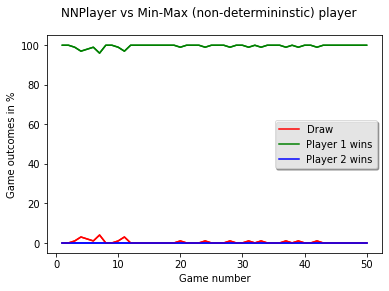

In [21]:
tf.reset_default_graph()    

nnplayer = NNQPlayer("QLearner1")
rnd_mm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(rnd_mm_player, nnplayer, num_battles = 50)

plt.suptitle("NNPlayer vs Min-Max (non-determininstic) player")

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation: 

Results are definitively not as expected; In most cases NNPlayer ended up playing slightly better than a random Min Max player, but not by much. Our NN Player never achieved consistently above 10% draws. 

#NN player V Tabular QL Player

NNPlayer plays first !

After 100 game we have draws: 4, Player 1 wins: 5, and Player 2 wins: 91.
Which gives percentages of draws: 4.00%, Player 1 wins: 5.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 1, Player 1 wins: 12, and Player 2 wins: 87.
Which gives percentages of draws: 1.00%, Player 1 wins: 12.00%, and Player 2 wins:  87.00%
After 100 game we have draws: 2, Player 1 wins: 20, and Player 2 wins: 78.
Which gives percentages of draws: 2.00%, Player 1 wins: 20.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 0, Player 1 wins: 2, and Player 2 wins: 98.
Which gives percentages of draws: 0.00%, Player 1 wins: 2.00%, and Player 2 wins:  98.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 10

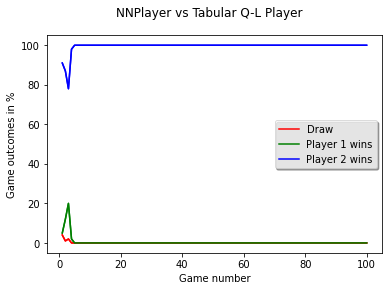

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, tqplayer)


plt.suptitle("NNPlayer vs Tabular Q-L Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:


NNPlayer at the max, wins 30% of the first few battles, but TQ Player quickly picks up and wins 100% of the time beyond 15 battles.

NN Player plays second

After 100 game we have draws: 0, Player 1 wins: 99, and Player 2 wins: 1.
Which gives percentages of draws: 0.00%, Player 1 wins: 99.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 0, Player 1 wins: 96, and Player 2 wins: 4.
Which gives percentages of draws: 0.00%, Player 1 wins: 96.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 97, and Player 2 wins: 2.
Which gives percentages of draws: 1.00%, Player 1 wins: 97.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 

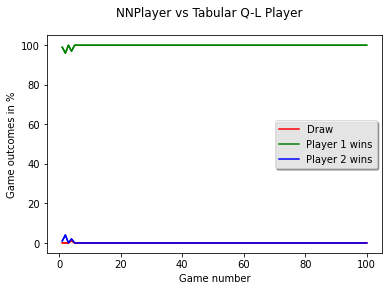

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(tqplayer,nnplayer)


plt.suptitle("NNPlayer vs Tabular Q-L Player")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

Observation:

As expected NNPlayer performs worse than when it played first. At its best,it draws 18% of the first few battles, before TQPlayer catches up and wins 100% of the time for the next 95 battles. 

#Other activation functions experimented:

We have experimented with the following **activation** functions:
1. tanh
2. leaky ReLu
3. sigmoid

Apart from Gradient descent optimzer, we have experimented with the  **Adam optimizer.**

# Activation functions

1. tanh activation function

After 100 game we have draws: 26, Player 1 wins: 54, and Player 2 wins: 20.
Which gives percentages of draws: 26.00%, Player 1 wins: 54.00%, and Player 2 wins:  20.00%
After 100 game we have draws: 7, Player 1 wins: 62, and Player 2 wins: 31.
Which gives percentages of draws: 7.00%, Player 1 wins: 62.00%, and Player 2 wins:  31.00%
After 100 game we have draws: 9, Player 1 wins: 61, and Player 2 wins: 30.
Which gives percentages of draws: 9.00%, Player 1 wins: 61.00%, and Player 2 wins:  30.00%
After 100 game we have draws: 13, Player 1 wins: 53, and Player 2 wins: 34.
Which gives percentages of draws: 13.00%, Player 1 wins: 53.00%, and Player 2 wins:  34.00%
After 100 game we have draws: 10, Player 1 wins: 68, and Player 2 wins: 22.
Which gives percentages of draws: 10.00%, Player 1 wins: 68.00%, and Player 2 wins:  22.00%
After 100 game we have draws: 7, Player 1 wins: 78, and Player 2 wins: 15.
Which gives percentages of draws: 7.00%, Player 1 wins: 78.00%, and Player 2 wins:  15.00

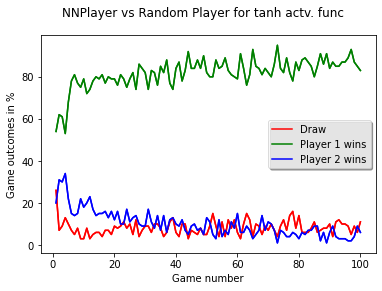

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player for tanh actv. func")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

2. Leaky ReLu activation function

After 100 game we have draws: 10, Player 1 wins: 64, and Player 2 wins: 26.
Which gives percentages of draws: 10.00%, Player 1 wins: 64.00%, and Player 2 wins:  26.00%
After 100 game we have draws: 1, Player 1 wins: 77, and Player 2 wins: 22.
Which gives percentages of draws: 1.00%, Player 1 wins: 77.00%, and Player 2 wins:  22.00%
After 100 game we have draws: 1, Player 1 wins: 82, and Player 2 wins: 17.
Which gives percentages of draws: 1.00%, Player 1 wins: 82.00%, and Player 2 wins:  17.00%
After 100 game we have draws: 10, Player 1 wins: 66, and Player 2 wins: 24.
Which gives percentages of draws: 10.00%, Player 1 wins: 66.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 1, Player 1 wins: 89, and Player 2 wins: 10.
Which gives percentages of draws: 1.00%, Player 1 wins: 89.00%, and Player 2 wins:  10.00%
After 100 game we have draws: 7, Player 1 wins: 77, and Player 2 wins: 16.
Which gives percentages of draws: 7.00%, Player 1 wins: 77.00%, and Player 2 wins:  16.00%


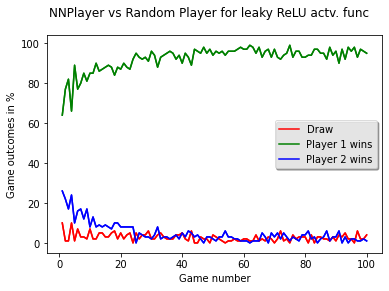

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player for leaky ReLU actv. func")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

3. sigmoid activation function

After 100 game we have draws: 7, Player 1 wins: 86, and Player 2 wins: 7.
Which gives percentages of draws: 7.00%, Player 1 wins: 86.00%, and Player 2 wins:  7.00%
After 100 game we have draws: 10, Player 1 wins: 80, and Player 2 wins: 10.
Which gives percentages of draws: 10.00%, Player 1 wins: 80.00%, and Player 2 wins:  10.00%
After 100 game we have draws: 16, Player 1 wins: 70, and Player 2 wins: 14.
Which gives percentages of draws: 16.00%, Player 1 wins: 70.00%, and Player 2 wins:  14.00%
After 100 game we have draws: 16, Player 1 wins: 57, and Player 2 wins: 27.
Which gives percentages of draws: 16.00%, Player 1 wins: 57.00%, and Player 2 wins:  27.00%
After 100 game we have draws: 8, Player 1 wins: 66, and Player 2 wins: 26.
Which gives percentages of draws: 8.00%, Player 1 wins: 66.00%, and Player 2 wins:  26.00%
After 100 game we have draws: 4, Player 1 wins: 73, and Player 2 wins: 23.
Which gives percentages of draws: 4.00%, Player 1 wins: 73.00%, and Player 2 wins:  23.00%


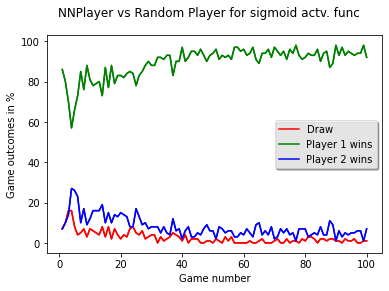

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
from RandomPlayer import RandomPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)


plt.suptitle("NNPlayer vs Random Player for sigmoid actv. func")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

#Adam Optimizer

After 100 game we have draws: 1, Player 1 wins: 20, and Player 2 wins: 79.
Which gives percentages of draws: 1.00%, Player 1 wins: 20.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 2, Player 1 wins: 19, and Player 2 wins: 79.
Which gives percentages of draws: 2.00%, Player 1 wins: 19.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 4, Player 1 wins: 18, and Player 2 wins: 78.
Which gives percentages of draws: 4.00%, Player 1 wins: 18.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 100 game we have draws: 0, Player 1 wins: 5, and Player 2 wins: 95.
Which gives percentages of draws: 0.00%, Player 1 wins: 5.00%, and Player 2 wins:  95.00%
After 100 game we have draws: 0, Player 1 wins: 0, and Player 2 wins: 100.
Which gives percentages of draws: 0.00%, Player 1 wins: 0.00%, and Player 2 wins:  100.00%
After 

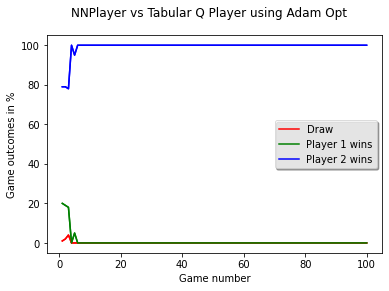

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
from TabularQPlayer import TQPlayer
from SimpleNNQPlayer import NNQPlayer

tf.reset_default_graph()  

nnplayer = NNQPlayer("QLearner1")
tbqplayer = TQPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, tbqplayer)


plt.suptitle("NNPlayer vs Tabular Q Player using Adam Opt")
p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

#Less Greedy Approach used as a solution to overcome the limitations in the above approach used in NN Player

##NNPlayer plays first

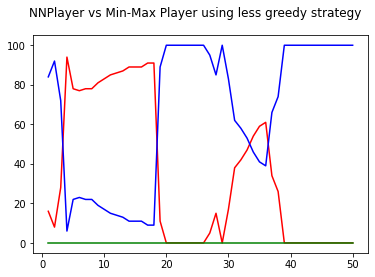

In [28]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from TFSessionManager import TFSessionManager
from RandomPlayer import RandomPlayer
from EGreedyNNQPlayer import EGreedyNNQPlayer
from MinMaxAgent import MinMaxAgent

tf.reset_default_graph()

nnplayer = EGreedyNNQPlayer("QLearner1", learning_rate=0.001, reward_discount=0.99, random_move_decrease=0.99)
mm_player = MinMaxAgent()
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player, num_battles=50,silent=True)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.suptitle("NNPlayer vs Min-Max Player using less greedy strategy")
plt.show()
TFSessionManager.set_session(None)



##NN Player goes second

After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 

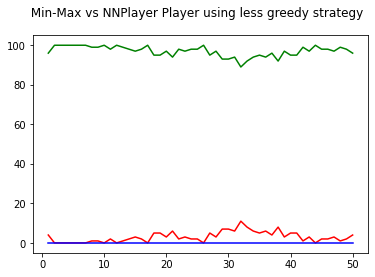

In [30]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from TFSessionManager import TFSessionManager
from RandomPlayer import RandomPlayer
from EGreedyNNQPlayer import EGreedyNNQPlayer
from RndMinMaxAgent import RndMinMaxAgent

tf.reset_default_graph()

nnplayer = EGreedyNNQPlayer("QLearner1", learning_rate=0.001, reward_discount=0.99, random_move_decrease=0.99)
mm_player = RndMinMaxAgent()
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(mm_player, nnplayer, num_battles=50)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.suptitle("Min-Max vs NNPlayer Player using less greedy strategy")
plt.show()
TFSessionManager.set_session(None)

#Summary

The summary of our results with this very simple Neural Network based player:

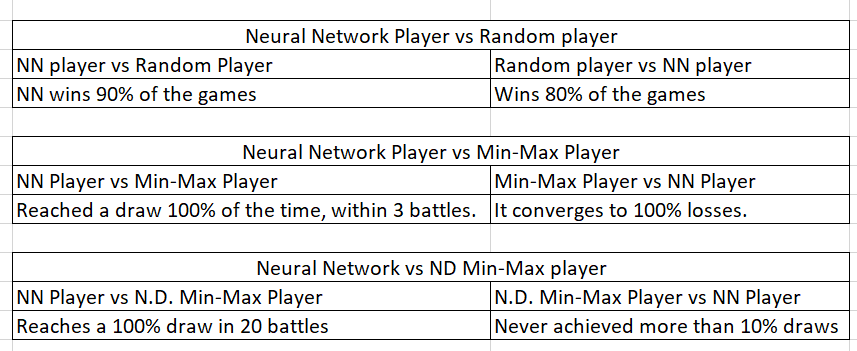